### Import necessary libraries

In [1]:
import tarfile
import os
import cv2
import numpy as np
import pickle
from PIL import Image, ExifTags
import tempfile
import tensorflow as tf
import shutil
print("TensorFlow version:", tf.__version__)
from deepface import DeepFace
print("DeepFace version:", DeepFace.__version__)

TensorFlow version: 2.19.0


C:\Users\USER\anaconda3\envs\image_processing_ass\lib\site-packages\mtcnn\mtcnn.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources



DeepFace version: 0.0.93


In [2]:
base_dir = "C:\\Users\\USER\\Documents\\image_assign"

# Data Preparation

#### Check suitability of dataset

In [2]:
unsuitable_images = []

for folder in range(1, 11):  # Folders 1 to 10
    folder_path = os.path.join(base_dir, str(folder))
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        try:
            faces = DeepFace.extract_faces(img_path, detector_backend="mtcnn", enforce_detection=True)
            if not faces or faces[0]["confidence"] < 0.9:  # Low confidence or no face detected
                unsuitable_images.append(img_path)
                print(f"Unsuitable: {img_path}")
        except ValueError as e:
            unsuitable_images.append(img_path)
            print(f"Error processing {img_path}: {e}")

print(f"Found {len(unsuitable_images)} unsuitable images: {unsuitable_images}")

1/1 [==============================] - 0s 22ms/step
Found 0 unsuitable images: []


### Checking for misoriented images

In [4]:
dataset_dir = os.path.join(base_dir, "asian_dataset")

# ✅ Get the EXIF tag number for 'Orientation'
orientation_tag = None
for tag, value in ExifTags.TAGS.items():
    if value == 'Orientation':
        orientation_tag = tag
        break

# ✅ Orientation values that indicate rotation or mirroring
bad_orientations = {2, 3, 4, 5, 6, 7, 8}

# ✅ Track problematic images
bad_images = []

# ✅ Loop through folders 1 to 10
for folder_id in range(1, 11):
    folder_path = os.path.join(dataset_dir, str(folder_id))
    if not os.path.isdir(folder_path):
        print(f"❌ Skipping missing folder: {folder_path}")
        continue

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                exif = img._getexif()
                if exif and orientation_tag in exif:
                    orientation = exif[orientation_tag]
                    if orientation in bad_orientations:
                        bad_images.append((folder_id, img_name, orientation))
                else:
                    # Optional: you could also log missing orientation tags
                    pass
        except Exception as e:
            print(f"⚠️ {img_path}: Error reading EXIF - {e}")

# ✅ Output results
if bad_images:
    print("\n⚠️ Misoriented Images Detected:")
    for folder_id, img_name, orientation in bad_images:
        print(f"Folder {folder_id} - {img_name}: Orientation tag = {orientation}")
else:
    print("✅ All images are correctly oriented or have no EXIF tag.")

✅ All images are correctly oriented or have no EXIF tag.


In [2]:
from PIL import Image, ExifTags, ImageOps
import os

base_dir = r"C:\Users\USER\Documents\image_assign"
dataset_dir = os.path.join(base_dir, "asian_dataset")

# Orientation tag lookup
orientation_tag = next(tag for tag, val in ExifTags.TAGS.items() if val == 'Orientation')

# Mapping of EXIF orientation values to transformations
orientation_fix = {
    2: lambda img: ImageOps.mirror(img),
    3: lambda img: img.rotate(180, expand=True),
    4: lambda img: ImageOps.flip(img),
    5: lambda img: ImageOps.mirror(img.rotate(-90, expand=True)),
    6: lambda img: img.rotate(-90, expand=True),
    7: lambda img: ImageOps.mirror(img.rotate(90, expand=True)),
    8: lambda img: img.rotate(90, expand=True),
}

fixed_count = 0

# Process folders 1 through 10
for folder_id in range(1, 11):
    folder_path = os.path.join(dataset_dir, str(folder_id))
    if not os.path.isdir(folder_path):
        print(f"❌ Skipping missing folder: {folder_path}")
        continue

    for img_name in os.listdir(folder_path):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(folder_path, img_name)

        try:
            with Image.open(img_path) as img:
                exif = img._getexif()
                if exif and orientation_tag in exif:
                    orientation = exif[orientation_tag]
                    if orientation in orientation_fix:
                        # Apply correction
                        corrected_img = orientation_fix[orientation](img)

                        # Overwrite image (or optionally save as new)
                        corrected_img.save(img_path)
                        fixed_count += 1
                        print(f"✅ Fixed: {img_path} (Orientation {orientation})")
        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")

print(f"\n🔧 Done! Fixed {fixed_count} misoriented image(s).")


✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_10.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_11.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_12.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_13.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_2.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_3.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_4.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_5.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_6.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_7.JPG (Orientation 5)
✅ Fixed: C:\Users\USER\Documents\image_assign\asian_dataset\4\Selfie_8.JPG (Orientatio

### Split dataset

In [12]:
import os
import shutil

# Destination directory
output_base_dir = os.path.join(base_dir, "data")

# Back up existing data directory (optional)
if os.path.exists(output_base_dir):
    backup_path = os.path.join(base_dir, "data_backup")
    shutil.copytree(output_base_dir, backup_path)
    print(f"Backed up existing data to {backup_path}")
    shutil.rmtree(output_base_dir)
    print("Deleted existing data directory.")

# Create new directories: database, valid, test
for subset in ['database', 'valid', 'test']:
    for folder in range(1, 11):  # Folders 1 to 10
        os.makedirs(os.path.join(output_base_dir, subset, str(folder)), exist_ok=True)

# Function to check if destination is already populated correctly
def is_split_complete(folder_path, subset, folder_num, expected_count):
    dest_path = os.path.join(output_base_dir, subset, str(folder_num))
    if os.path.exists(dest_path):
        files = [f for f in os.listdir(dest_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        return len(files) == expected_count
    return False

# Split images for each folder
for folder in range(1, 11):  # Folders 1 to 10
    folder_path = os.path.join(base_dir, "asian_dataset", str(folder))
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    images.sort()  # Sort to ensure consistent order (Selfie_1 to Selfie_13)

    if len(images) == 13:  # Expecting 13 images per folder
        # Check if splits are already complete
        if (is_split_complete(folder_path, 'database', folder, 1) and
            is_split_complete(folder_path, 'valid', folder, 6) and
            is_split_complete(folder_path, 'test', folder, 6)):
            print(f"Folder {folder} already split correctly. Skipping.")
            continue

        # Database set (single profile image: Selfie_1)
        profile_img = images[0]  # Use Selfie_1 as the profile picture
        src_path = os.path.join(folder_path, profile_img)
        dst_path = os.path.join(output_base_dir, 'database', str(folder), profile_img)
        shutil.copy(src_path, dst_path)
        print(f"Copied {profile_img} to database/{folder}/")

        # Validation set (Selfie_2 to Selfie_7)
        for img in images[1:7]:
            src_path = os.path.join(folder_path, img)
            dst_path = os.path.join(output_base_dir, 'valid', str(folder), img)
            shutil.copy(src_path, dst_path)
            print(f"Copied {img} to valid/{folder}/")

        # Test set (Selfie_8 to Selfie_13)
        for img in images[7:]:
            src_path = os.path.join(folder_path, img)
            dst_path = os.path.join(output_base_dir, 'test', str(folder), img)
            shutil.copy(src_path, dst_path)
            print(f"Copied {img} to test/{folder}/")
    else:
        print(f"Warning: Folder {folder} does not contain exactly 13 images. Found {len(images)} images.")

print("Dataset split complete. Verify the data/database, data/valid, and data/test directories.")

Backed up existing data to C:\Users\USER\Documents\image_assign\data_backup
Deleted existing data directory.
Copied Selfie_1.jpg to database/1/
Copied Selfie_10.jpg to valid/1/
Copied Selfie_11.jpg to valid/1/
Copied Selfie_12.jpg to valid/1/
Copied Selfie_13.jpg to valid/1/
Copied Selfie_2.jpg to valid/1/
Copied Selfie_3.jpg to valid/1/
Copied Selfie_4.jpg to test/1/
Copied Selfie_5.jpg to test/1/
Copied Selfie_6.jpg to test/1/
Copied Selfie_7.jpg to test/1/
Copied Selfie_8.jpg to test/1/
Copied Selfie_9.jpg to test/1/
Copied Selfie_1.jpg to database/2/
Copied Selfie_10.jpg to valid/2/
Copied Selfie_11.jpg to valid/2/
Copied Selfie_12.jpg to valid/2/
Copied Selfie_13.jpg to valid/2/
Copied Selfie_2.jpg to valid/2/
Copied Selfie_3.jpg to valid/2/
Copied Selfie_4.jpg to test/2/
Copied Selfie_5.jpg to test/2/
Copied Selfie_6.jpg to test/2/
Copied Selfie_7.jpg to test/2/
Copied Selfie_8.jpg to test/2/
Copied Selfie_9.jpg to test/2/
Copied Selfie_1.jpg to database/3/
Copied Selfie_10.jpg t

### Simulate a database

In [5]:
import os
from deepface import DeepFace
import numpy as np
import pickle

base_dir = "C:\\Users\\USER\\Documents\\image_assign"
file_path = os.path.join(base_dir, "embeddings_students.pkl")
output_base_dir = os.path.join(base_dir, "data")

# Load existing embeddings if file exists (but we'll overwrite for single-image version)
embeddings_db = {}
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        embeddings_db = pickle.load(f)
        print(f"Loaded existing embeddings from {file_path} (will update to single-image)")

def img_to_encoding(img_path, model_name="Facenet"):
    img = DeepFace.represent(img_path, model_name=model_name, enforce_detection=False)[0]["embedding"]
    return np.array(img) / np.linalg.norm(img)

for folder in range(1, 11):  # Folders 1 to 10
    person_id = f"Person_{folder}"
    # Use only one image as the "profile picture" (e.g., Selfie_1 from train)
    profile_img_num = 1  # Change this if you want a different one (e.g., 5 for a middle image)
    for ext in ['.jpg', '.jpeg']:
        img_path = os.path.join(output_base_dir, "train", str(folder), f"Selfie_{profile_img_num}{ext}")
        if os.path.exists(img_path):
            embedding = img_to_encoding(img_path)
            embeddings_db[person_id] = [embedding]  # Store as list for consistency, but it's single
            print(f"Added {person_id} with single embedding from {img_path}")
            break
    else:
        print(f"No valid profile image found for {person_id}")

# Save updated single-image embeddings
with open(file_path, 'wb') as f:
    pickle.dump(embeddings_db, f)
print(f"Saved single-image embeddings to {file_path}")

Added Person_1 with single embedding from C:\Users\USER\Documents\image_assign\data\train\1\Selfie_1.jpg
Added Person_2 with single embedding from C:\Users\USER\Documents\image_assign\data\train\2\Selfie_1.jpg
Added Person_3 with single embedding from C:\Users\USER\Documents\image_assign\data\train\3\Selfie_1.jpg
Added Person_4 with single embedding from C:\Users\USER\Documents\image_assign\data\train\4\Selfie_1.jpg
Added Person_5 with single embedding from C:\Users\USER\Documents\image_assign\data\train\5\Selfie_1.jpg
Added Person_6 with single embedding from C:\Users\USER\Documents\image_assign\data\train\6\Selfie_1.jpg
Added Person_7 with single embedding from C:\Users\USER\Documents\image_assign\data\train\7\Selfie_1.jpeg
Added Person_8 with single embedding from C:\Users\USER\Documents\image_assign\data\train\8\Selfie_1.jpeg
Added Person_9 with single embedding from C:\Users\USER\Documents\image_assign\data\train\9\Selfie_1.jpeg
Added Person_10 with single embedding from C:\Users\

### Test Accuracy for pretrained model

In [7]:
import os
from deepface import DeepFace
import numpy as np
import pickle
from scipy.spatial.distance import cosine

# Paths as before
file_path = os.path.join(base_dir, "embeddings_students.pkl")
output_base_dir = os.path.join(base_dir, "data")

# Load single-image embeddings
with open(file_path, 'rb') as f:
    embeddings_db = pickle.load(f)
    print(f"Loaded single-image embeddings for {len(embeddings_db)} people")

def img_to_encoding(img_path, model_name="Facenet"):
    img = DeepFace.represent(img_path, model_name=model_name, enforce_detection=False)[0]["embedding"]
    return np.array(img) / np.linalg.norm(img)

# List of thresholds to test
thresholds = [0.4, 0.5, 0.6, 0.7]

# Store results for each threshold
results = {}

for threshold in thresholds:
    correct_matches = 0
    total_tests = 0

    # Test on valid and test sets (excluding the profile image if it's in train)
    for subset in ['valid', 'test']:  # You could add 'train' but exclude the profile one
        for folder in range(1, 11):
            folder_path = os.path.join(output_base_dir, subset, str(folder))
            if os.path.exists(folder_path):
                images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                images.sort()
                for img in images:
                    test_img_path = os.path.join(folder_path, img)
                    if os.path.exists(test_img_path):
                        test_embedding = img_to_encoding(test_img_path)
                        min_distance = float('inf')
                        best_match = None

                        for person_id, embedding_list in embeddings_db.items():
                            embedding = embedding_list[0]  # Single embedding
                            distance = cosine(test_embedding, embedding)
                            if distance < min_distance:
                                min_distance = distance
                                best_match = person_id

                        total_tests += 1
                        expected_match = f"Person_{folder}"
                        print(f"\nThreshold: {threshold}")
                        print(f"Image: {img} (Folder {folder}, {subset})")
                        if min_distance < threshold:
                            print(f"Best match: {best_match} with distance {min_distance}")
                            if best_match == expected_match:
                                correct_matches += 1
                                print("Correct match!")
                            else:
                                print("Incorrect match!")
                        else:
                            print(f"No match found (distance {min_distance} > threshold {threshold})")
                    else:
                        print(f"Test image {test_img_path} does not exist. Skipping.")

    accuracy = (correct_matches / total_tests) * 100 if total_tests > 0 else 0
    results[threshold] = accuracy
    print(f"\nThreshold {threshold} - Total tests: {total_tests}")
    print(f"Threshold {threshold} - Correct matches: {correct_matches}")
    print(f"Threshold {threshold} - Accuracy: {accuracy:.2f}%")

print("\nSingle-image threshold testing complete.")
print("Results:", results)

Loaded single-image embeddings for 10 people

Threshold: 0.4
Image: Selfie_6.jpg (Folder 1, valid)
Best match: Person_1 with distance 0.1788823723656524
Correct match!

Threshold: 0.4
Image: Selfie_7.jpg (Folder 1, valid)
Best match: Person_1 with distance 0.1544663336093811
Correct match!

Threshold: 0.4
Image: Selfie_6.jpg (Folder 2, valid)
Best match: Person_2 with distance 0.2553397606323814
Correct match!

Threshold: 0.4
Image: Selfie_7.jpg (Folder 2, valid)
Best match: Person_2 with distance 0.22399558497249494
Correct match!

Threshold: 0.4
Image: Selfie_6.jpg (Folder 3, valid)
Best match: Person_6 with distance 0.3723375298946544
Incorrect match!

Threshold: 0.4
Image: Selfie_7.jpg (Folder 3, valid)
Best match: Person_10 with distance 0.22283885863587194
Incorrect match!

Threshold: 0.4
Image: Selfie_6.JPG (Folder 4, valid)
Best match: Person_4 with distance 0.3835453306088048
Correct match!

Threshold: 0.4
Image: Selfie_7.JPG (Folder 4, valid)
Best match: Person_4 with distanc

### Augment data

In [14]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Number of augmented images per original
NUM_AUG_PER_IMAGE = 20
TARGET_AUGMENTED_COUNT = 21  # 1 original + 20 augmented

# Directories
database_dir = os.path.join(output_base_dir, 'database')
aug_train_dir = os.path.join(output_base_dir, 'train_augmented')

# Create augmented directory structure
os.makedirs(aug_train_dir, exist_ok=True)
for person_id in os.listdir(database_dir):
    person_folder = os.path.join(database_dir, person_id)
    if os.path.isdir(person_folder):
        os.makedirs(os.path.join(aug_train_dir, person_id), exist_ok=True)

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=15.0
)

# Augment images
for person_id in os.listdir(database_dir):
    person_folder = os.path.join(database_dir, person_id)
    output_folder = os.path.join(aug_train_dir, person_id)
    if not os.path.isdir(person_folder):
        continue

    # Check existing images
    existing_files = [f for f in os.listdir(output_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(existing_files) >= TARGET_AUGMENTED_COUNT:
        print(f"✅ Skipping {person_id}: already has {len(existing_files)} images.")
        continue

    # Copy original image
    img_name = [f for f in os.listdir(person_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][0]
    img_path = os.path.join(person_folder, img_name)
    shutil.copy(img_path, os.path.join(output_folder, img_name))
    print(f"Copied original {img_name} to {output_folder}")

    # Generate augmentations
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    aug_iter = datagen.flow(
        x,
        batch_size=1,
        save_to_dir=output_folder,
        save_prefix='aug',
        save_format='jpg'
    )
    for i in range(NUM_AUG_PER_IMAGE):
        current_count = len([f for f in os.listdir(output_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        if current_count >= TARGET_AUGMENTED_COUNT:
            print(f"✅ Reached target count for {person_id}: {current_count} images.")
            break
        next(aug_iter)

print("✅ Augmentation complete! Augmented images saved to:", aug_train_dir)

Copied original Selfie_1.jpg to C:\Users\USER\Documents\image_assign\data\train_augmented\1
Copied original Selfie_1.jpg to C:\Users\USER\Documents\image_assign\data\train_augmented\10
Copied original Selfie_1.jpg to C:\Users\USER\Documents\image_assign\data\train_augmented\2
Copied original Selfie_1.jpg to C:\Users\USER\Documents\image_assign\data\train_augmented\3
Copied original Selfie_1.JPG to C:\Users\USER\Documents\image_assign\data\train_augmented\4
Copied original Selfie_1.jpg to C:\Users\USER\Documents\image_assign\data\train_augmented\5
Copied original Selfie_1.jpg to C:\Users\USER\Documents\image_assign\data\train_augmented\6
Copied original Selfie_1.jpeg to C:\Users\USER\Documents\image_assign\data\train_augmented\7
Copied original Selfie_1.jpeg to C:\Users\USER\Documents\image_assign\data\train_augmented\8
Copied original Selfie_1.jpeg to C:\Users\USER\Documents\image_assign\data\train_augmented\9
✅ Augmentation complete! Augmented images saved to: C:\Users\USER\Documents\

### Detect and crop faces from images with mtcnn

In [ ]:
import os
import cv2
from mtcnn.mtcnn import MTCNN

# Directories
input_dir = os.path.join(output_base_dir, "train_augmented")
output_dir = os.path.join(output_base_dir, "train_faces")

# Create output folder structure
os.makedirs(output_dir, exist_ok=True)
for person_id in os.listdir(input_dir):
    person_path = os.path.join(input_dir, person_id)
    if os.path.isdir(person_path):
        os.makedirs(os.path.join(output_dir, person_id), exist_ok=True)

# Initialize MTCNN
detector = MTCNN()

# Image size for Facenet
IMG_SIZE = (160, 160)

# Track failed detections
failed_images = []

# Process images
for person_id in os.listdir(input_dir):
    person_folder = os.path.join(input_dir, person_id)
    output_person_folder = os.path.join(output_dir, person_id)
    if not os.path.isdir(person_folder):
        continue

    for img_name in os.listdir(person_folder):
        img_path = os.path.join(person_folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            failed_images.append(img_path)
            print(f"❌ Failed to load {img_path}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect faces
        results = detector.detect_faces(img_rgb)
        if not results or results[0]['confidence'] < 0.9:
            failed_images.append(img_path)
            print(f"❌ No face or low confidence in {img_path}")
            continue

        # Crop face
        x, y, w, h = results[0]['box']
        x, y = max(0, x), max(0, y)
        face = img_rgb[y:y+h, x:x+w]
        if face.size == 0:
            failed_images.append(img_path)
            print(f"❌ Empty face crop for {img_path}")
            continue

        # Resize
        face = cv2.resize(face, IMG_SIZE)

        # Save
        out_path = os.path.join(output_person_folder, img_name)
        cv2.imwrite(out_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
        print(f"Saved face for {img_name} to {out_path}")

print(f"✅ Face cropping complete! Faces saved to: {output_dir}")
print(f"❌ Failed to process {len(failed_images)} images: {failed_images}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Saved face for aug_0_1359.jpg to C:\Users\USER\Documents\image_assign\data\train_faces\1\aug_0_1359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━

In [17]:
import os
import cv2
from mtcnn.mtcnn import MTCNN

# Input and output folders
input_dirs = {
    'valid': r"C:\Users\USER\Documents\image_assign\data\valid",
    'test': r"C:\Users\USER\Documents\image_assign\data\test"
}
output_dirs = {
    'valid': r"C:\Users\USER\Documents\image_assign\data\valid_faces",
    'test': r"C:\Users\USER\Documents\image_assign\data\test_faces"
}

# Initialize MTCNN
detector = MTCNN()
IMG_SIZE = (160, 160)

# Track failed detections
failed_images = { 'valid': [], 'test': [] }

# Process valid and test sets
for split in ['valid', 'test']:
    input_dir = input_dirs[split]
    output_dir = output_dirs[split]
    os.makedirs(output_dir, exist_ok=True)

    for person_id in os.listdir(input_dir):
        person_folder = os.path.join(input_dir, person_id)
        output_person_folder = os.path.join(output_dir, person_id)
        if not os.path.isdir(person_folder):
            continue
        os.makedirs(output_person_folder, exist_ok=True)

        for img_name in os.listdir(person_folder):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(person_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                failed_images[split].append(img_path)
                print(f"❌ Failed to load {img_path} ({split})")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = detector.detect_faces(img_rgb)
            if not results or results[0]['confidence'] < 0.9:
                failed_images[split].append(img_path)
                print(f"❌ No face or low confidence in {img_path} ({split})")
                continue

            x, y, w, h = results[0]['box']
            x, y = max(0, x), max(0, y)
            face = img_rgb[y:y+h, x:x+w]
            if face.size == 0:
                failed_images[split].append(img_path)
                print(f"❌ Empty face crop for {img_path} ({split})")
                continue

            face = cv2.resize(face, IMG_SIZE)
            out_path = os.path.join(output_person_folder, img_name)
            cv2.imwrite(out_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
            print(f"Saved face for {img_name} to {out_path} ({split})")

    print(f"✅ Done cropping faces for {split} set → saved to: {output_dir}")
    print(f"❌ Failed to process {len(failed_images[split])} images in {split} set: {failed_images[split]}")

print(f"Total failed detections: valid={len(failed_images['valid'])}, test={len(failed_images['test'])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Saved face for Selfie_10.JPG to C:\Users\USER\Documents\image_assign\data\valid_faces\4\Selfie_10.JPG (valid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Saved face for Selfie_11.JPG to C:\Users\USER\Docum

### Generate Embeddings with FaceNet

In [19]:
from keras_facenet import FaceNet
import numpy as np
import os
import cv2
import pickle
from tensorflow.keras.utils import to_categorical

# Paths
base_dir = r"C:\Users\USER\Documents\image_assign\data"
IMG_SIZE = (160, 160)
embedder = FaceNet()

# Output directory for embeddings
output_dir = r"C:\Users\USER\Documents\image_assign\embeddings"
os.makedirs(output_dir, exist_ok=True)

# Split folders
splits = {
    "database": "database",  # For enrollment
    "train": "train_faces",
    "valid": "valid_faces",
    "test": "test_faces"
}

def process_split(split_name, folder_name):
    print(f"[INFO] Processing {split_name} data...")
    X, y = [], []
    label_map = {}
    failed_images = []

    split_path = os.path.join(base_dir, folder_name)
    for idx, class_name in enumerate(sorted(os.listdir(split_path))):
        class_path = os.path.join(split_path, class_name)
        if not os.path.isdir(class_path):
            continue
        label_map[idx] = f"Person_{class_name}"  # e.g., Person_1
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                failed_images.append(img_path)
                print(f"❌ Failed to load {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if split_name == "database":  # Resize only for database (not pre-cropped)
                img = cv2.resize(img, IMG_SIZE)
            X.append(img)
            y.append(idx)

    if not X:
        print(f"❌ No valid images found for {split_name}")
        return

    X = np.array(X)
    # One-hot encode for train/valid/test, integer labels for database
    y_cat = to_categorical(y, num_classes=len(label_map)) if split_name != "database" else np.array(y)

    print(f"[INFO] Generating embeddings for {split_name} ({len(X)} images)...")
    try:
        embeddings = embedder.embeddings(X)
        if np.any(np.isnan(embeddings)) or np.any(np.isinf(embeddings)):
            print(f"❌ Invalid embeddings detected in {split_name}")
            return
    except Exception as e:
        print(f"❌ Error generating embeddings for {split_name}: {e}")
        return

    # Save embeddings
    with open(os.path.join(output_dir, f"{split_name}_embeddings.pkl"), "wb") as f:
        pickle.dump({
            "embeddings": embeddings,
            "labels": y_cat if split_name != "database" else y,
            "label_map": label_map,
            "failed_images": failed_images
        }, f)
    print(f"✅ Saved {split_name} embeddings to {split_name}_embeddings.pkl")
    print(f"Failed images: {len(failed_images)}")

# Process all splits
for split_name, folder_name in splits.items():
    process_split(split_name, folder_name)

print("✅ Embedding generation complete!")

[INFO] Processing database data...
[INFO] Generating embeddings for database (10 images)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Saved database embeddings to database_embeddings.pkl
Failed images: 0
[INFO] Processing train data...
[INFO] Generating embeddings for train (210 images)...
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step
✅ Saved train embeddings to train_embeddings.pkl
Failed images: 0
[INFO] Processing valid data...
[INFO] Generating embeddings for valid (60 images)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
✅ Saved valid embeddings to valid_embeddings.pkl
Failed images: 0
[INFO] Processing test data...
[INFO] Generating embeddings for test (60 images)...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
✅ Saved test embeddings to test_embeddings.pkl
Failed images: 0
✅ Embedding generation complete!


### Transfer Learning

Train embeddings: 210 (failed: 0)
Valid embeddings: 60 (failed: 0)
Test embeddings: 60 (failed: 0)
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3636 - loss: 4.1374 - val_accuracy: 0.9667 - val_loss: 3.6090
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9597 - loss: 3.3936 - val_accuracy: 1.0000 - val_loss: 3.0317
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9974 - loss: 2.8102 - val_accuracy: 1.0000 - val_loss: 2.5572
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9815 - loss: 2.3366 - val_accuracy: 1.0000 - val_loss: 2.1702
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9398 - val_accuracy: 1.0000 - val_loss: 1.8648
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5891 - val_accuracy: 1.0000 - val_loss: 1.6250
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4278 - val_accuracy: 1.0000 - val_loss: 1.4443


✅ Saved updated classifier trained on FaceNet embeddings.
Final training accuracy: 1.00
Final validation accuracy: 1.00


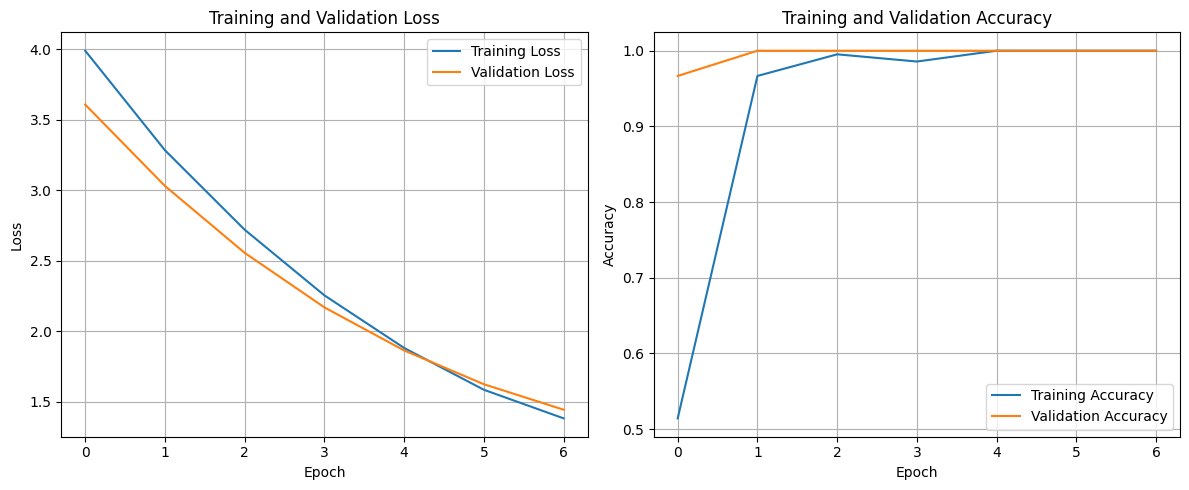

✅ Saved training metrics plot as 'training_metrics.png'

✅ Evaluating on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Test Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

    Person_1       1.00      1.00      1.00         6
   Person_10       1.00      1.00      1.00         6
    Person_2       1.00      1.00      1.00         6
    Person_3       1.00      1.00      1.00         6
    Person_4       1.00      1.00      1.00         6
    Person_5       1.00      1.00      1.00         6
    Person_6       1.00      1.00      1.00         6
    Person_7       1.00      1.00      1.00         6
    Person_8       1.00      1.00      1.00         6
    Person_9       1.00      1.00      1.00         6

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [8]:
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
import os
import matplotlib.pyplot as plt

# Path to embedding .pkl files
embedding_dir = r"C:\Users\USER\Documents\image_assign\embeddings"

def load_embeddings(file_name):
    with open(os.path.join(embedding_dir, file_name), "rb") as f:
        data = pickle.load(f)
    embeddings = np.array(data["embeddings"])
    labels = np.array(data["labels"])
    label_map = data["label_map"]
    failed_images = data.get("failed_images", [])
    # Convert one-hot to indices if needed
    if labels.ndim > 1 and labels.shape[1] > 1:
        labels = np.argmax(labels, axis=1)
    return embeddings, labels, label_map, failed_images

# Load datasets
X_train, y_train, label_map, train_failed = load_embeddings("train_embeddings.pkl")
X_valid, y_valid, _, valid_failed = load_embeddings("valid_embeddings.pkl")
X_test, y_test, _, test_failed = load_embeddings("test_embeddings.pkl")

# Print embedding counts
print(f"Train embeddings: {X_train.shape[0]} (failed: {len(train_failed)})")
print(f"Valid embeddings: {X_valid.shape[0]} (failed: {len(valid_failed)})")
print(f"Test embeddings: {X_test.shape[0]} (failed: {len(test_failed)})")
NUM_CLASSES = len(label_map)

# One-hot encode
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_valid_cat = to_categorical(y_valid, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

# Build classifier
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model with early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=16,
    validation_data=(X_valid, y_valid_cat),
    callbacks=[early_stopping]
)

# Save model
model.save(os.path.join(embedding_dir, "facenet_embed_classifier.h5"))
print("✅ Saved updated classifier trained on FaceNet embeddings.")

# Print training results
print(f"Final training accuracy: {history.history['accuracy'][-1]:.2f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.2f}")

# Visualize loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(embedding_dir, "training_metrics.png"))
plt.show()
print("✅ Saved training metrics plot as 'training_metrics.png'")

# Evaluate on test set
print("\n✅ Evaluating on test set...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

print("Test Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=[label_map[i] for i in sorted(label_map)]))

In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random

# Initialize lists for similarities
intra_class_sims = []
inter_class_sims = []

# Group embeddings by class
class_embeddings = {i: [] for i in range(10)}  # 10 people
for idx, label in enumerate(y_train):
    class_embeddings[label].append(X_train[idx])

# Compute intra-class and inter-class similarities
num_pairs = 50
for _ in range(num_pairs):
    # Intra-class: Randomly select a person and two embeddings
    person = random.randint(0, 9)
    if len(class_embeddings[person]) < 2:
        continue
    idx1, idx2 = random.sample(range(len(class_embeddings[person])), 2)
    sim = cosine_similarity([class_embeddings[person][idx1]], [class_embeddings[person][idx2]])[0][0]
    intra_class_sims.append(sim)

    # Inter-class: Select two different people
    person1, person2 = random.sample(range(10), 2)
    idx1 = random.randint(0, len(class_embeddings[person1]) - 1)
    idx2 = random.randint(0, len(class_embeddings[person2]) - 1)
    sim = cosine_similarity([class_embeddings[person1][idx1]], [class_embeddings[person2][idx2]])[0][0]
    inter_class_sims.append(sim)

# Compute averages
intra_mean = np.mean(intra_class_sims) if intra_class_sims else 0
inter_mean = np.mean(inter_class_sims) if inter_class_sims else 0

print(f"Average intra-class cosine similarity (same person, {len(intra_class_sims)} pairs): {intra_mean:.4f}")
print(f"Average inter-class cosine similarity (different people, {len(inter_class_sims)} pairs): {inter_mean:.4f}")
print(f"Suggested cosine similarity threshold for deployment: {(intra_mean + inter_mean) / 2:.4f}")

Average intra-class cosine similarity (same person, 50 pairs): 0.9704
Average inter-class cosine similarity (different people, 50 pairs): 0.2929
Suggested cosine similarity threshold for deployment: 0.6317


### live feed for face/qr detection

In [3]:
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os

# Paths
embedding_dir = r"C:\Users\USER\Documents\image_assign\embeddings"
model_path = r"C:\Users\USER\Documents\image_assign\facenet_embed_classifier.h5"
IMG_SIZE = (160, 160)

# Initialize models
detector = MTCNN()
embedder = FaceNet()
classifier = load_model(model_path)

# Load database embeddings for cosine similarity
with open(os.path.join(embedding_dir, "database_embeddings.pkl"), "rb") as f:
    db_data = pickle.load(f)
    db_embeddings = db_data["embeddings"]
    db_labels = db_data["labels"]
    db_label_map = db_data["label_map"]

# Initialize video capture (use 0 for webcam, or specify a video file)
cap = cv2.VideoCapture(0)  # Replace with "test_video.mp4" for testing
qr_detector = cv2.QRCodeDetector()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Convert frame to RGB for MTCNN
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect face
    results = detector.detect_faces(frame_rgb)
    if results and results[0]['confidence'] >= 0.9:
        x, y, w, h = results[0]['box']
        x, y = max(0, x), max(0, y)
        face = frame_rgb[y:y+h, x:x+w]
        if face.size == 0:
            print("Empty face crop detected")
            continue
        face = cv2.resize(face, IMG_SIZE)
        
        # Compute embedding
        face_embedding = embedder.embeddings(np.array([face]))[0]
        
        # Option 1: Cosine similarity with database embeddings
        max_sim = -1
        best_match_sim = None
        for idx, db_emb in enumerate(db_embeddings):
            sim = cosine_similarity([face_embedding], [db_emb])[0][0]
            if sim > max_sim:
                max_sim = sim
                best_match_sim = db_label_map[db_labels[idx]]
        threshold = 0.65  # Based on your suggested 0.6317
        if max_sim > threshold:
            sim_result = f"Cosine Match: {best_match_sim} (similarity: {max_sim:.3f})"
        else:
            sim_result = "Cosine: No match found"
        
        # Option 2: Classifier prediction
        pred = classifier.predict(np.array([face_embedding]))
        pred_class = np.argmax(pred, axis=1)[0]
        pred_conf = pred[0][pred_class]
        if pred_conf > 0.2:  # Confidence threshold
            clf_result = f"Classifier Match: {db_label_map[pred_class]} (confidence: {pred_conf:.3f})"
        else:
            clf_result = "Classifier: No match found"
        
        # QR code scanning
        qr_data, bbox, _ = qr_detector.detectAndDecode(frame)
        qr_result = f"QR Code: {qr_data}" if qr_data else "QR Code: Not detected"
        
        # Display results
        print(f"{sim_result} | {clf_result} | {qr_result}")
        
        # Draw bounding box and results on frame
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f"{best_match_sim if max_sim > threshold else 'Unknown'}", 
                    (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    else:
        print("No face detected")
    
    # Display frame
    cv2.imshow("Convocation Face Recognition", frame)
    
    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Cosine Match: Person_10 (similarity: 0.733) | Classifier Match: Person_10 (confidence: 0.233) | QR Code: Not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Cosine Match: Person_10 (similarity: 0.694) | Classifier Match: Person_10 (confidence: 0.218) | QR Code: Not detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1

### computing accuracy using test and validation sets

In [2]:
import os
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import pickle

# Paths
base_dir = r"C:\Users\USER\Documents\image_assign\data"
embedding_dir = r"C:\Users\USER\Documents\image_assign\embeddings"
model_path = r"C:\Users\USER\Documents\image_assign\facenet_embed_classifier.h5"
IMG_SIZE = (160, 160)

# Initialize models
detector = MTCNN()
embedder = FaceNet()
classifier = load_model(model_path)

# Load label map from database_embeddings.pkl for consistency
with open(os.path.join(embedding_dir, "database_embeddings.pkl"), "rb") as f:
    db_data = pickle.load(f)
    db_label_map = db_data["label_map"]

# Function to load images and true labels from a split
def load_images_and_labels(split_folder):
    images = []
    true_labels = []
    for folder in range(1, 11):  # Folders 1 to 10 (Person_1 to Person_10)
        folder_path = os.path.join(base_dir, split_folder, str(folder))
        if os.path.exists(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    # Map folder name to label (0-9) using db_label_map
                    person_name = f"Person_{folder}"
                    for label, name in db_label_map.items():
                        if name == person_name:
                            true_labels.append(label)
                            break
    return np.array(images), np.array(true_labels)

# Function to generate embeddings with MTCNN cropping
def generate_embeddings(images):
    embeddings = []
    for img in images:
        results = detector.detect_faces(img)
        if results and results[0]['confidence'] >= 0.9:
            x, y, w, h = results[0]['box']
            x, y = max(0, x), max(0, y)
            face = img[y:y+h, x:x+w]
            if face.size == 0:
                print("Empty face crop detected, skipping image")
                continue
            face = cv2.resize(face, IMG_SIZE)
            embedding = embedder.embeddings(np.array([face]))[0]
            embeddings.append(embedding)
        else:
            print("No face detected, skipping image")
    return np.array(embeddings)

# Function to test on a split and calculate accuracy
def test_split(split_folder, split_name):
    print(f"\nTesting on {split_name} set...")
    images, true_labels = load_images_and_labels(split_folder)
    if len(images) == 0:
        print(f"No images found in {split_name} set.")
        return None

    # Generate embeddings
    embeddings = generate_embeddings(images)
    if len(embeddings) != len(true_labels):
        print(f"Warning: {len(embeddings)} embeddings generated, but {len(true_labels)} images provided.")
        true_labels = true_labels[:len(embeddings)]  # Adjust labels to match

    if len(embeddings) == 0:
        print(f"No valid embeddings generated for {split_name} set.")
        return None

    # Predict with classifier
    preds = classifier.predict(embeddings, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    pred_confs = np.max(preds, axis=1)

    # Calculate accuracy
    acc = accuracy_score(true_labels, pred_classes)
    print(f"{split_name} Accuracy: {acc * 100:.2f}%")

    # Print details for each image
    for i in range(len(true_labels)):
        print(f"Image {i+1}: True Label = {db_label_map[true_labels[i]]}, Predicted = {db_label_map[pred_classes[i]]}, Confidence = {pred_confs[i]:.3f}")

    return acc

# Option: Test with precomputed embeddings for consistency
def test_precomputed_embeddings(split_file, split_name):
    print(f"\nTesting on precomputed {split_name} embeddings...")
    with open(os.path.join(embedding_dir, split_file), "rb") as f:
        data = pickle.load(f)
    embeddings = data["embeddings"]
    true_labels = np.argmax(data["labels"], axis=1)  # Convert one-hot to class indices

    # Predict with classifier
    preds = classifier.predict(embeddings, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    pred_confs = np.max(preds, axis=1)

    # Calculate accuracy
    acc = accuracy_score(true_labels, pred_classes)
    print(f"{split_name} Accuracy: {acc * 100:.2f}%")

    # Print details
    for i in range(len(true_labels)):
        print(f"Image {i+1}: True Label = {db_label_map[true_labels[i]]}, Predicted = {db_label_map[pred_classes[i]]}, Confidence = {pred_confs[i]:.3f}")

    return acc

# Test on valid and test sets
valid_acc = test_split("valid_faces", "Validation")
test_acc = test_split("test_faces", "Test")
valid_precomputed_acc = test_precomputed_embeddings("valid_embeddings.pkl", "Validation (Precomputed)")
test_precomputed_acc = test_precomputed_embeddings("test_embeddings.pkl", "Test (Precomputed)")

print("\nSummary:")
print(f"Validation Accuracy (Images): {valid_acc * 100 if valid_acc is not None else 'N/A':.2f}%")
print(f"Test Accuracy (Images): {test_acc * 100 if test_acc is not None else 'N/A':.2f}%")
print(f"Validation Accuracy (Precomputed): {valid_precomputed_acc * 100 if valid_precomputed_acc is not None else 'N/A':.2f}%")
print(f"Test Accuracy (Precomputed): {test_precomputed_acc * 100 if test_precomputed_acc is not None else 'N/A':.2f}%")

C:\Users\USER\anaconda3\envs\image_processing_ass\lib\site-packages\mtcnn\mtcnn.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources



Testing on Validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━

### just generating new embeddings to use for the website

In [2]:
import cv2
import numpy as np
from keras_facenet import FaceNet
import pickle
import os

# Paths
base_dir = r"C:\Users\USER\Documents\image_assign\data"
embedding_dir = r"C:\Users\USER\Documents\image_assign\embeddings"
IMG_SIZE = (160, 160)

# Initialize FaceNet
embedder = FaceNet()

# Map folder names to student IDs (e.g., folder '1' -> 'S001')
folder_to_student_id = {
    "1": "S001",
    "2": "S002",
    "3": "S003",
    "4": "S004",
    "5": "S005",
    "6": "S006",
    "7": "S007",
    "8": "S008",
    "9": "S009",
    "10": "S010"
}

def process_database():
    print("[INFO] Processing database for student embeddings...")
    X, y = [], []
    label_map = {}
    failed_images = []
    idx = 0

    database_path = os.path.join(base_dir, "database")
    for folder_name in sorted(os.listdir(database_path)):
        if folder_name not in folder_to_student_id:
            print(f"⚠ Skipping unknown folder: {folder_name}")
            continue
        student_id = folder_to_student_id[folder_name]
        class_path = os.path.join(database_path, folder_name)
        if not os.path.isdir(class_path):
            continue

        label_map[idx] = student_id  # Map index to student_id (e.g., 0 -> "S001")
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                failed_images.append(img_path)
                print(f"❌ Failed to load {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            X.append(img)
            y.append(idx)
        idx += 1

    if not X:
        print("❌ No valid images found for database")
        return

    X = np.array(X)
    y = np.array(y)
    print(f"[INFO] Generating embeddings for {len(X)} images...")
    try:
        embeddings = embedder.embeddings(X)
        if np.any(np.isnan(embeddings)) or np.any(np.isinf(embeddings)):
            print("❌ Invalid embeddings detected")
            return
    except Exception as e:
        print(f"❌ Error generating embeddings: {e}")  
        return

    # Save embeddings
    os.makedirs(embedding_dir, exist_ok=True)
    output_path = os.path.join(embedding_dir, "flask_app_embeddings.pkl")
    with open(output_path, "wb") as f:
        pickle.dump({
            "embeddings": embeddings,
            "labels": y,
            "label_map": label_map,
            "failed_images": failed_images
        }, f)
    print(f"✅ Saved student embeddings to {output_path}")
    print(f"Label map: {label_map}")
    print(f"Failed images: {len(failed_images)}")

# Process database
process_database()
print("✅ Student embedding generation complete!")



[INFO] Processing database for student embeddings...
[INFO] Generating embeddings for 10 images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Saved student embeddings to C:\Users\USER\Documents\image_assign\embeddings\flask_app_embeddings.pkl
Label map: {0: 'S001', 1: 'S010', 2: 'S002', 3: 'S003', 4: 'S004', 5: 'S005', 6: 'S006', 7: 'S007', 8: 'S008', 9: 'S009'}
Failed images: 0
✅ Student embedding generation complete!
